In [ ]:
import warnings
warnings.simplefilter("ignore")
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from numpy import expand_dims
from numpy import mean
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
#sys.path.append('/home/ubuntu/Mask_RCNN/samples/coco') 
#import coco
%matplotlib inline
import itertools
import colorsys
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display
from mrcnn import utils
from PIL import Image

Processing 1 images
image                    shape: (640, 1024, 3)        min: -123.70000  max:  115.10000  float64
molded_images            shape: (1, 1024, 1024, 3)    min: -247.40000  max:   11.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



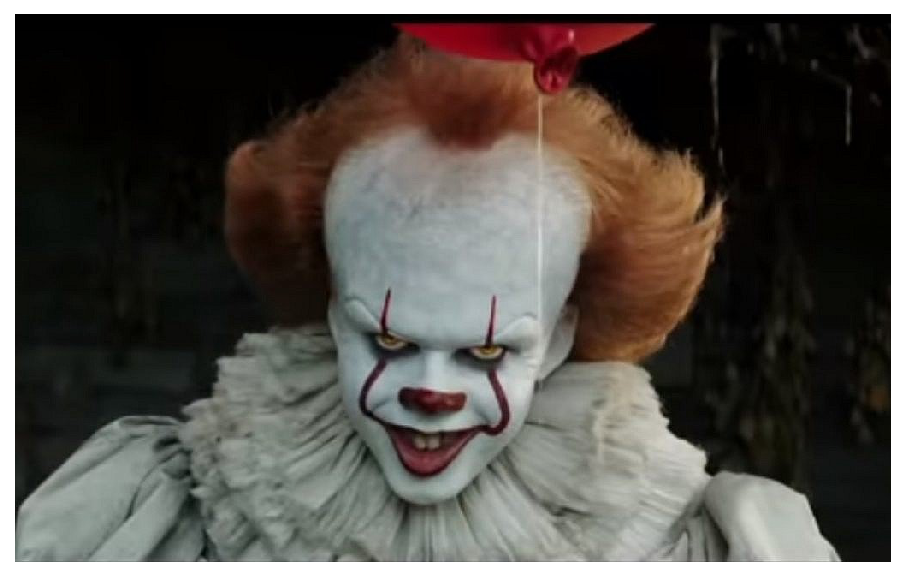

Processing 1 images
image                    shape: (720, 1280, 3)        min: -123.70000  max:  131.30000  float64
molded_images            shape: (1, 1024, 1024, 3)    min: -247.40000  max:   19.34062  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



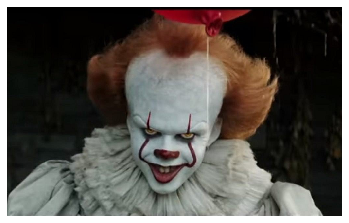

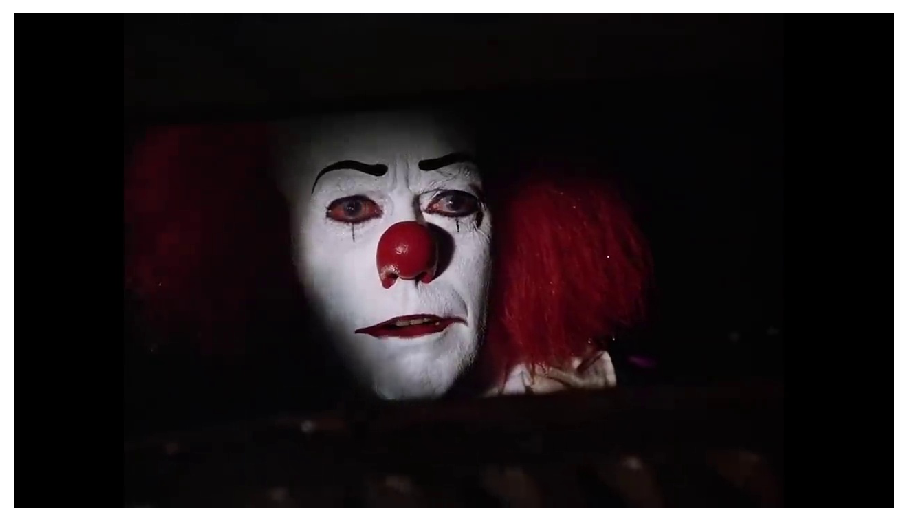

Processing 1 images
image                    shape: (194, 259, 3)         min: -123.70000  max:  151.10000  float64
molded_images            shape: (1, 1024, 1024, 3)    min: -247.40000  max:   46.98771  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


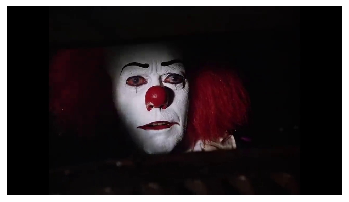

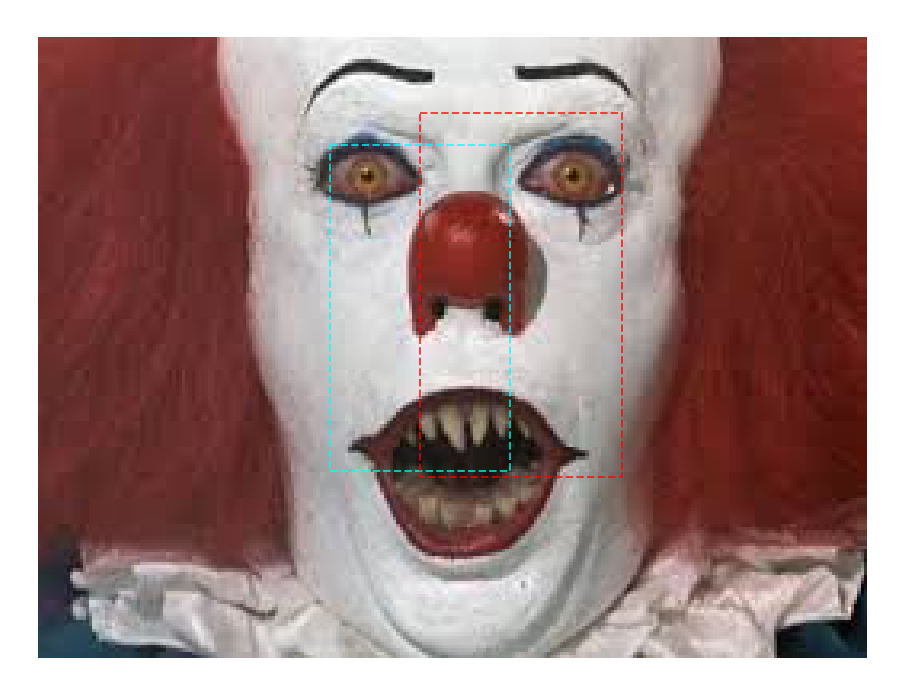

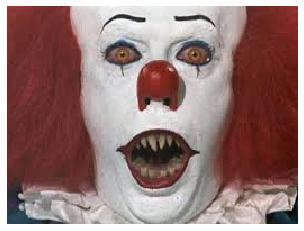

In [5]:
n_images = 3


# source code from visulaize.py
def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None, imagecount=0):

    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        #if not captions:
        #    class_id = class_ids[i]
        #    score = scores[i] if scores is not None else None
        #    label = class_names[class_id]
        #    caption = "{} {:.3f}".format(label, score) if score else label
        #else:
        #    caption = captions[i]
        #ax.text(x1, y1 + 8, caption, color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:                  
            masked_image = apply_mask(masked_image, mask, color)   

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            #Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    #plt.savefig(f"/home/ubuntu/Mask_RCNN/data/outputAllFrame/{imagecount}.jpg", bbox_inches='tight', pad_inches=-0.5,orientation= 'landscape')  #save output
    if auto_show:
        plt.show()

        
        
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors
     
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image





# Begining the ClownDataset
class ClownDataset(Dataset):
	def load_dataset(self, dataset_dir, is_train=True):
		self.add_class("dataset", 1, "clown")
		self.add_class("dataset", 2, "others")   #mod**
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		for filename in listdir(images_dir):
			image_id = filename[:-4]
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path, class_ids=[0,1,2]) 

	def extract_boxes(self, filename):
		tree = ElementTree.parse(filename)
		root = tree.getroot()
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	def load_mask(self, image_id):
		info = self.image_info[image_id]
		path = info['annotation']
		boxes, w, h = self.extract_boxes(path)
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			if i == 0:                                    
				masks[row_s:row_e, col_s:col_e, i] = 1                  
				class_ids.append(self.class_names.index('clown'))      
			else:                                         
				masks[row_s:row_e, col_s:col_e, i] = 2                 
				class_ids.append(self.class_names.index('others'))     
		return masks, asarray(class_ids, dtype='int32')                

	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

    
class PredictionConfig(Config):
	NAME = "Clown_cfg"
	NUM_CLASSES = 1 + 2
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

    

def plot_predicted_new(dataset, model, cfg, n_images = n_images):    #works for segmentation (not bb)
    for i in range(n_images):
        image = dataset.load_image(i)
        scaled_image = mold_image(image, cfg)
        sample = expand_dims(scaled_image, 0)        
        class_names = ['BG', "clown", "others"] 
        yhat = model.detect(sample, verbose=1)[0]     #check
        r = yhat
        display_instances(image, r['rois'], r['masks'],  r['class_ids'], class_names, scores=True, imagecount=i,
        show_bbox=True, captions=True, show_mask=True) 
    
        a, b, c, d =[], [], [], []
        for n in range(len(r['rois'])):
            if class_names[r['class_ids'][n]] == 'clown':
                a.append(r['rois'][n][0])
                b.append(r['rois'][n][1])
                c.append(r['rois'][n][2])
                d.append(r['rois'][n][3])
                
        try:
            mask = np.ones(image.shape)
            mask[min(a):max(c), min(b):max(d)] = 0
            mask1 = mask.astype(bool)
            masked = image*mask1
            plt.imshow(masked)
            plt.axis('off')
            plt.savefig(f"/home/ubuntu/Mask_RCNN/data/outputMaskFrame/{i}.jpg", transparent=True)

        except:
            pass
        
        plt.imshow(image)
        plt.axis('off')
        plt.savefig(f"/home/ubuntu/Mask_RCNN/data/outputAllFrame/{i}.jpg", transparent=True)

        
def main():
   
    test_set = ClownDataset()
    test_set.load_dataset('/home/ubuntu/Mask_RCNN/data/validation', is_train=False)
    test_set.prepare()
    cfg = PredictionConfig()  
    model_path = '/home/ubuntu/Mask_RCNN/models/mask_rcnn_clown_cfg_0001.h5'
    model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
    model.load_weights(model_path, by_name=True)
    plot_predicted_new(test_set, model, cfg)
    

if __name__ == '__main__':
    main()


In [ ]:
# use to check!!!
image = skimage.io.imread('/home/ubuntu/Mask_RCNN/data/validation/images/ae983231cf.jpg')
cfg = PredictionConfig()
scaled_image = mold_image(image, cfg)
sample = expand_dims(scaled_image, 0)        
class_names = ['BG', "clown", "others"]

model_path = '/home/ubuntu/Mask_RCNN/models/mask_rcnn_clown_cfg_0001.h5'
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model.load_weights(model_path, by_name=True)
yhat = model.detect(sample, verbose=1)[0]
r = yhat      
display_instances(image, r['rois'], r['masks'],  r['class_ids'], class_names, scores=False, 
show_bbox=True, captions=True, show_mask=True) 